In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Load relevant data**

In [2]:
# Translation table
translation_df = pd.read_csv('data/external/candSID_PanAfID_translations_old_platform_2021_11_27.csv')
translation_df['video'] = translation_df['clip.id'].str.lower()
translation_df['video_id'] = translation_df['video.id'].str.lower()
translation_df['new_file_name'] = translation_df['new.file.name'].str.lower()
translation_df.drop(columns=['Unnamed: 0', 'clip.id', 'video.id', 'new.file.name'], inplace=True)

In [3]:
# ACP prefixed videos
acp_df = pd.read_csv('data/internal/acp_prefixed_videos.csv', names=['video'], header=None)
acp_df.video = acp_df.video.str.split('.').str[0].str.lower()

In [4]:
# Maureens annotations
csv_files = glob('/home/dl18206/Desktop/phd/data/panaf/maureen_annotations/data/sites/csv/**/*.csv', recursive=True)
sorted_csv_files = sorted(csv_files, key=lambda x: x.split('/')[-1])
initialiser, remainder = sorted_csv_files[0], sorted_csv_files[1:]
df = pd.read_csv(initialiser, encoding="ISO-8859-1")
for file in remainder:
    site = pd.read_csv(file, encoding="ISO-8859-1")
    df = pd.concat([df, site])
df['subdir_video'] = df.subfolder.astype(str) + '_' + df.video_file_name.astype(str)
df['subdir_video'] = df.subdir_video.str.lower()
df['subdir_video'] = df.subdir_video.str.split('.').str[0]

In [5]:
print(f'Unique videos translation table: {translation_df.video.unique().__len__()}')
print(f'Unique videos translation table: {acp_df.video.unique().__len__() }')

Unique videos translation table: 562805
Unique videos translation table: 19977


**Merge acp-prefixed and translation dataframes**

In [6]:
acp_trans_df = acp_df.merge(translation_df, on='video')
# Create subdir_video column to allow downstream merging with 
acp_trans_df['subdir_video'] = acp_trans_df.new_file_name.apply(lambda x: '_'.join(x.split('/')[-2:]))
acp_trans_df['subdir_video'] = acp_trans_df.subdir_video.apply(lambda x: x.split('.')[0])
acp_trans_df.drop(columns=['video_id', 'new_file_name'], inplace=True)

**Chimp & See annotations**

In [7]:
# Read chimp and see annotations and merge with acp-prefixed and translation dataframes
chimp_df = pd.read_excel('data/internal/Chimp & See master chimpanzee video list 2015-2018_OB_analysis.xlsx', sheet_name="Otto's Analysis (Plain Text)")
chimp_df['video'] = chimp_df.ID.str.lower()
all_df = acp_trans_df.merge(chimp_df, on='video')

# Convert tags to list of tokens
all_df['split_tags'] = all_df.Tags.str.split(' ')

In [8]:
# Import unique tag analysis
tag_df = pd.read_excel('/home/dl18206/Downloads/unique_tags 1.xlsx', sheet_name='distilled')

attr = tag_df.columns[1:]
for col in tag_df.columns[1:]:
    unique_tags = tag_df[tag_df[col]==col].tags.unique()
    all_df[col] = all_df.split_tags.apply(lambda x: 1 if any(i in x for i in unique_tags) else 0)
    
# Create column indicating empties
all_df['label_indicator'] = all_df[tag_df.columns[1:]].astype(int).apply(lambda x: True if any([i for i in x]) else False, axis=1)

In [9]:
# Multi-class label conversion
# Define a lambda function to convert binary columns to a multiclass label
to_label = lambda x: ','.join([str(i) for i in x])

# Apply the lambda function to each row to create a new column 'label'
all_df['label'] = all_df[tag_df.columns[1:]].astype(int).apply(to_label, axis=1).astype('category')
all_df['label'] = all_df.label.str.split(',')
all_df['label'] = all_df.label.apply(lambda x: [int(i) for i in x])

# print output
# all_df.label.value_counts()

In [10]:
counts_df1 = all_df[all_df.label_indicator==True]
counts_df1.drop(counts_df1.columns.difference(['video', 'subdir_video']), axis=1, inplace=True)
counts_df1 = counts_df1.merge(df, on='subdir_video')
counts_df1 = counts_df1.groupby('video')['max_number_chimps_per_video'].apply(lambda x: x.unique()[0] if len(x.unique())==1 else False).reset_index()

<ipython-input-10-3121c666ac36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_df1.drop(counts_df1.columns.difference(['video', 'subdir_video']), axis=1, inplace=True)


In [11]:
counts_df1

,video,max_number_chimps_per_video
0,acp000002j,3.0
1,acp000002l,3.0
2,acp00000nk,8.0
3,acp00001qd,3.0
4,acp00001qf,3.0
...,...,...
6861,acp000dz3r,7.0
6862,acp000dzoy,2.0
6863,acp000dzp0,2.0
6864,acp000e0cs,4.0


**Investigate videos without any behavioural annotation**

In [12]:
acp_trans_panaf_df = acp_trans_df.merge(df, on='subdir_video')
acp_trans_panaf_df.columns

Index(['video', 'site', 'subdir_video', 'new_row_id', 'country',
       'research_site', 'genus', 'species', 'cam_coverage_area',
       'location_metadata', 'habitat', 'utm_zone', 'utm_long', 'utm_lat',
       'cam_id', 'vid_res', 'vid_duration', 'panaf_datasheet_comments', 'year',
       'month', 'day', 'time_hr', 'time_min', 'cell_id', 'subfolder',
       'video_file_name', 'event_id', 'min_number_chimps_per_video',
       'max_number_chimps_per_video', 'age_class', 'sex', 'tool_use',
       'vocalization', 'bipedal', 'camera_reaction', 'behavioral_context',
       'other_species', 'additional_comments', 'record_type'],
      dtype='object')

In [13]:
# Filter ONLY videos which have 0 behavioural annotation
no_annotations = all_df[all_df.label_indicator==False]['video']
acp_trans_df = acp_trans_df[acp_trans_df.video.isin(no_annotations)]

In [14]:
# Merging PanAf annotations with new platform
acp_trans_panaf_df = acp_trans_df.merge(df, on='subdir_video')

In [15]:
(acp_trans_panaf_df.behavioral_context.value_counts() / acp_trans_panaf_df.behavioral_context.value_counts().sum()) * 100

travel             44.255987
feeding            33.725952
climbing            8.197880
resting             4.687868
unclear             2.669808
camera reaction     1.743227
playing             1.295642
tool use            1.107185
tool use nuts       1.005104
displaying          0.612485
grooming            0.369062
sexual              0.141343
greeting            0.094229
reassurance         0.047114
aggression          0.047114
Name: behavioral_context, dtype: float64

In [16]:
counts_df2 = acp_trans_panaf_df.groupby('video')['max_number_chimps_per_video'].apply(lambda x: x.unique()[0] if len(x.unique())==1 else False).reset_index()

In [17]:
# Merging
counts_df = pd.concat([counts_df1, counts_df2], axis=0)
counts_df.drop_duplicates()

,video,max_number_chimps_per_video
0,acp000002j,3.0
1,acp000002l,3.0
2,acp00000nk,8.0
3,acp00001qd,3.0
4,acp00001qf,3.0
...,...,...
5504,acp000dyqz,8.0
5505,acp000dzmo,1.0
5506,acp000dzow,2.0
5507,acp000dzp1,2.0


In [18]:
counts_df[counts_df.max_number_chimps_per_video>20]

,video,max_number_chimps_per_video
4561,acp000dg2m,21.0
4562,acp000dg2o,21.0
4563,acp000dg2q,21.0


In [78]:
counts_df.to_csv('counts.csv', index=False)

In [15]:
# Remove all columns except video_id and behavioural context
acp_trans_panaf_df.drop(acp_trans_panaf_df.columns.difference(['video', 'site', 'behavioral_context', 'tool_use','vocalization', 'bipedal', 'camera_reaction']), 1, inplace=True)
acp_trans_panaf_df.fillna('no', inplace=True)

# Convert behavioural context to multiple columns with binary indicators
behavioural_context_df = pd.get_dummies(acp_trans_panaf_df, columns=['behavioral_context'])
behavioural_context_df.replace({'yes': 1, 'off_camera':1, 'offscreen':1, 'no': 0}, inplace=True)

# Unify labels for multiple sub classes
behavioural_context_df['true_tool_use']=(behavioural_context_df.tool_use==1)|(behavioural_context_df['behavioral_context_tool use']==1)|(behavioural_context_df['behavioral_context_tool use nuts']==1)
behavioural_context_df['true_camera_reaction']=(behavioural_context_df['camera_reaction']==1)|(behavioural_context_df['behavioral_context_camera reaction']==1)
behavioural_context_df['true_tool_use'] = behavioural_context_df['true_tool_use'].astype(int)
behavioural_context_df['true_camera_reaction'] = behavioural_context_df['true_camera_reaction'].astype(int)

<ipython-input-15-faa76119fa2d>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  acp_trans_panaf_df.drop(acp_trans_panaf_df.columns.difference(['video', 'site', 'behavioral_context', 'tool_use','vocalization', 'bipedal', 'camera_reaction']), 1, inplace=True)


In [16]:
behavioural_context_df.drop(columns=['tool_use', 'camera_reaction', 'behavioral_context_camera reaction', 'behavioral_context_greeting', 'behavioral_context_resting', 'behavioral_context_tool use', 'behavioral_context_tool use nuts', 'behavioral_context_unclear'], inplace=True)

In [17]:
behavioural_context_df.columns

Index(['video', 'site', 'vocalization', 'bipedal',
       'behavioral_context_aggression', 'behavioral_context_climbing',
       'behavioral_context_displaying', 'behavioral_context_feeding',
       'behavioral_context_grooming', 'behavioral_context_playing',
       'behavioral_context_reassurance', 'behavioral_context_sexual',
       'behavioral_context_travel', 'true_tool_use', 'true_camera_reaction'],
      dtype='object')

In [18]:
behavioural_context_df.rename(
    columns={
    "vocalization": "vocalisation", 
    "behavioral_context_aggression": "aggression", 
    "behavioral_context_climbing":"climbing", 
    "behavioral_context_displaying":"display", 
    "behavioral_context_feeding":"feeding", 
    "behavioral_context_grooming":"grooming",
    "behavioral_context_sexual":"sex", 
    "behavioral_context_travel":"travel",
    "true_tool_use": "tool_use",
    "true_camera_reaction": "camera_reaction",
    },
    inplace=True
)

behavioural_context_df['social_interaction']=(behavioural_context_df.behavioral_context_playing==1)|(behavioural_context_df.behavioral_context_reassurance==1)
behavioural_context_df['social_interaction'] = behavioural_context_df['social_interaction'].astype(int)
behavioural_context_df.drop(columns=['behavioral_context_playing', 'behavioral_context_reassurance'], inplace=True)

In [19]:
behavioural_context_df

,video,site,vocalisation,bipedal,aggression,climbing,display,feeding,grooming,sex,travel,tool_use,camera_reaction,social_interaction
0,acp000cfoz,bwindi,0,0,0,0,0,0,0,0,1,0,0,0
1,acp00055t9,east_nimba,0,0,0,0,0,0,0,0,1,0,0,0
2,acp00072rb,kayan,0,0,0,0,0,0,0,0,1,0,0,0
3,acp00072rb,kayan,0,0,0,0,0,0,0,0,1,0,0,0
4,acp00072ra,kayan,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12730,acp000ds3g,ngogo,0,0,0,0,0,1,0,0,0,0,0,0
12731,acp000ds3g,ngogo,0,0,0,0,0,1,0,0,0,0,1,0
12732,acp000ds3g,ngogo,0,0,0,0,0,1,0,0,0,0,0,0
12733,acp000drq3,ngogo,0,0,0,0,0,1,0,0,0,0,1,0


In [20]:
to_label = lambda x: ','.join([str(i) for i in x])

# Apply the lambda function to each row to create a new column 'label'
behavioural_context_df['label'] = behavioural_context_df[behavioural_context_df.columns[2:]].apply(to_label, axis=1).astype('category')
behavioural_context_df['label'] = behavioural_context_df.label.str.split(',')
behavioural_context_df['label'] = behavioural_context_df.label.apply(lambda x: str([int(i) for i in x]))

In [21]:
multi_label_df = behavioural_context_df.groupby('video')['label'].apply(lambda x: True if len(x.unique())==1 else False).reset_index()
multi_label_df = multi_label_df[multi_label_df.label==True]

In [22]:
videos2keep = multi_label_df.video
behavioural_context_df = behavioural_context_df[behavioural_context_df.video.isin(videos2keep)]

In [23]:
behavioural_context_df.drop(behavioural_context_df.columns.difference(['video', 'site', 'travel', 'feeding']), axis=1, inplace=True)

<ipython-input-23-acd5c8556b5c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavioural_context_df.drop(behavioural_context_df.columns.difference(['video', 'site', 'travel', 'feeding']), axis=1, inplace=True)


In [24]:
behavioural_context_df

,video,site,feeding,travel
0,acp000cfoz,bwindi,0,1
1,acp00055t9,east_nimba,0,1
2,acp00072rb,kayan,0,1
3,acp00072rb,kayan,0,1
4,acp00072ra,kayan,0,1
...,...,...,...,...
12718,acp000ba92,budongo,0,1
12719,acp000bb8w,budongo,0,1
12720,acp000bb8w,budongo,0,1
12721,acp000dtt9,ngogo,1,0


**Combine ACP-prefixed data with Maureens annotations**

In [22]:
all_df = all_df[all_df.label_indicator==True]
all_df.drop(columns=['site', 'subdir_video', 'ID', 'Tags', 'Unnamed: 2', 'split_tags', 'label_indicator', 'label'], inplace=True)

missing_columns = [x for x in all_df.columns if x not in behavioural_context_df.columns]
for col in missing_columns:
    behavioural_context_df[col] = 0
final_df = pd.concat([all_df, behavioural_context_df]).drop_duplicates()

**Process final df: index cols, add label indicator etc.**

In [23]:
sorted_columns_df = final_df.reindex(sorted(all_df.columns[1:-5]), axis=1)
video_df = final_df[final_df.columns[:1]]
indicator_df = final_df[final_df.columns[-5:]]
final_df = pd.concat([video_df, indicator_df, sorted_columns_df], axis=1)

# Create column indicating empties
final_df['label_indicator'] = final_df[final_df.columns[6:]].astype(int).apply(lambda x: True if any([i for i in x]) else False, axis=1)

final_df = final_df[final_df.label_indicator==True].drop(columns=['label_indicator'])

**Qualitative testing: vis samples**

In [24]:
# Lazy: for ease of typing
f = final_df

In [25]:
f[f.vocalisation==1]

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,display,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation
13,acp000cf1d,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39,acp000fwgo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
40,acp00048kt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
46,acp000cawr,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,acp000cew4,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,acp000fwgl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14481,acp000cmy0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14484,acp000cevt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14486,acp000cc9r,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
final_df.columns[6:]

Index(['aggression', 'bipedal', 'camera_reaction', 'chimp_carrying',
       'climbing', 'defecating', 'display', 'drinking', 'feeding', 'grooming',
       'piloerection', 'sex', 'social_interaction', 'tool_use', 'travel',
       'vocalisation'],
      dtype='object')

**Summary and distribution**

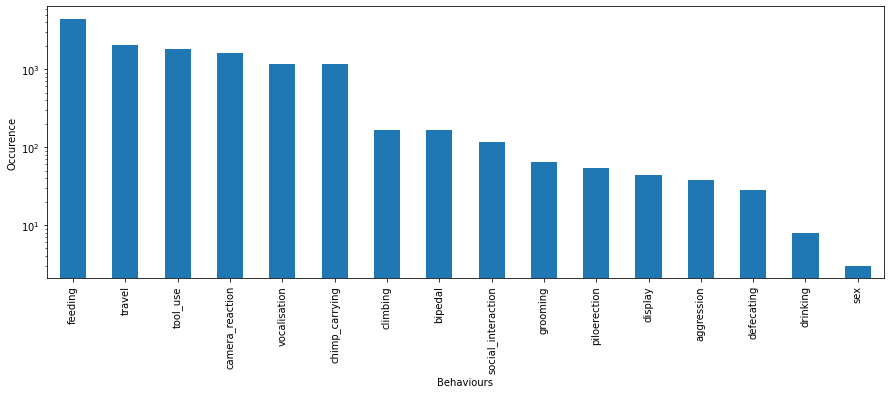

In [27]:
# Plot freq dist
attr = final_df.columns[6:]
counts=final_df[attr].sum(axis=0).sort_values(ascending=False) # occurence counts
ax = counts.plot.bar(figsize=(15,5));
plt.yscale('log');
ax.set_xlabel("Behaviours");
ax.set_ylabel("Occurence");

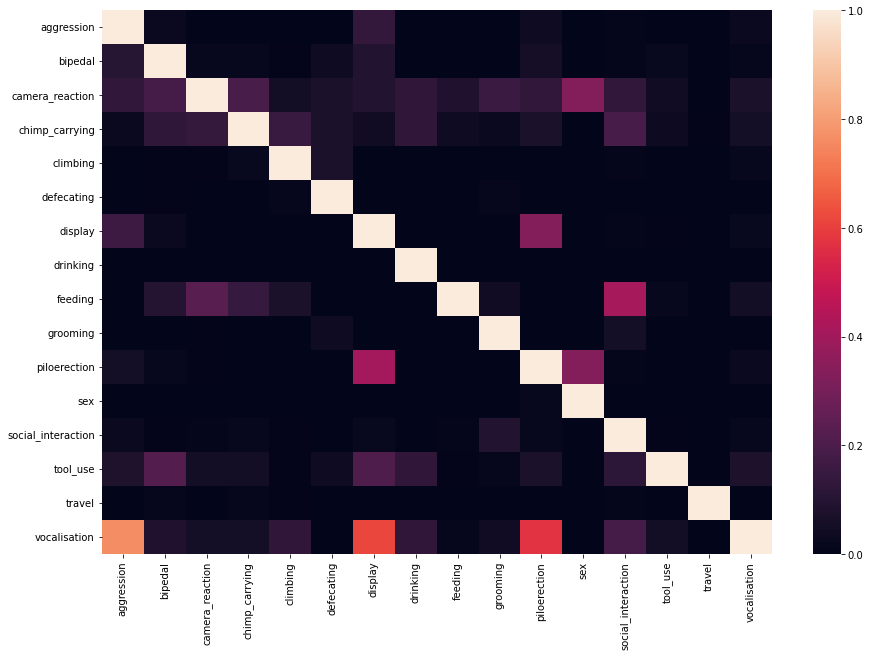

In [28]:
# Plot co-occurence matrix
coocc_df = final_df[attr].astype(int)
coocc = coocc_df.T.dot(coocc_df)

# Make sure it is relative for vis
diag = np.diag(coocc)
rel_co_matrix = np.array([1 / x for x in diag]) * coocc

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(rel_co_matrix);

In [29]:
# Apply the lambda function to each row to create a new column 'label'
final_df['label'] = final_df[final_df.columns[6:]].apply(to_label, axis=1).astype('category')
final_df['label'] = final_df.label.str.split(',')
final_df['label'] = final_df.label.apply(lambda x: str([int(i) for i in x]))

In [30]:
label_counts = pd.DataFrame(f.label.value_counts())

In [31]:
label_counts[label_counts.label>100].label.sum()

10463

In [32]:
label_counts[label_counts.label>20]

,label
"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",3823
"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",2008
"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",1530
"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",881
"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",827
"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",666
"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",333
"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",172
"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",120
"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",103


In [41]:
final_df

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation,label
0,acp000capq,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,acp000fw7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
5,acp000b37u,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
6,acp0002rqx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
7,acp000cwcu,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12712,acp000c4li,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
12718,acp000ba92,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
12719,acp000bb8w,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
12721,acp000dtt9,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [43]:
attr

Index(['aggression', 'bipedal', 'camera_reaction', 'chimp_carrying',
       'climbing', 'defecating', 'display', 'drinking', 'feeding', 'grooming',
       'piloerection', 'sex', 'social_interaction', 'tool_use', 'travel',
       'vocalisation'],
      dtype='object')